In [84]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [67]:
df = pd.concat([pd.read_csv(f) for f in glob.glob('cork_property_prices*.csv')], ignore_index = True)

In [68]:
print("Number of rows before dedupes:,", len(df))
df = df.drop_duplicates(subset='listing_id', keep='first') # Dedup on listing_id and keep first record.
print("Number of rows after dedupes:,", len(df))
print("Number of unique properties: ", df.listing_id.nunique())

Number of rows before dedupes:, 1397
Number of rows after dedupes:, 232
Number of unique properties:  232


In [69]:
df.head()
df.describe()
df.shape

(232, 9)

In [70]:
# Clean data
df['cost'] = df['cost'].str.replace(",","") # Remove commas in cost column
df = df[(df.cost.str.isnumeric() == True)] # Remove rows with alpha characters
df['cost'] = pd.to_numeric(df['cost'])
df['cost'] = df['cost']/1000

# Create an ordinal equivalent of BER
df['ber'] = pd.Categorical(df['ber'])
df['ber_ord'] = df.ber.cat.codes
type(df['ber_ord'])

pandas.core.series.Series

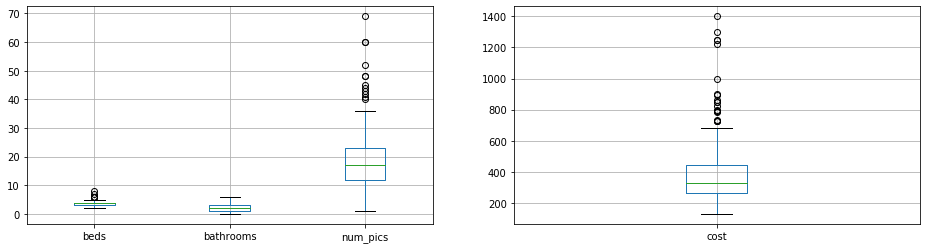

In [71]:
plt.rcParams['figure.figsize'] = [16, 4]
plt.tight_layout()
plt.subplot(1, 2, 1)
pd.DataFrame(df,columns=["beds","bathrooms","num_pics"]).boxplot()
plt.subplot(1, 2, 2)
pd.DataFrame(df,columns=["cost"]).boxplot()

<Figure size 1152x288 with 0 Axes>

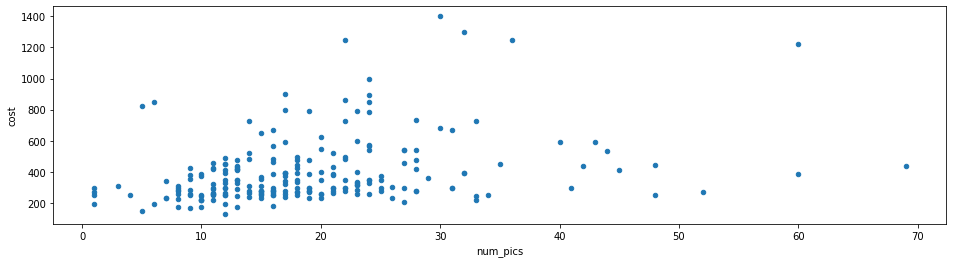

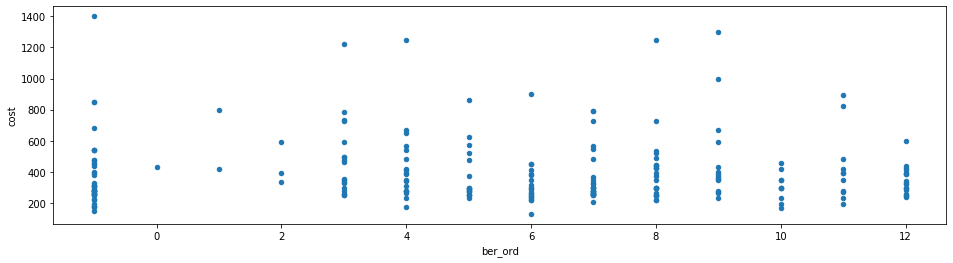

In [72]:
# Visual exploration
plt.rcParams['figure.figsize'] = [16, 4]
plt.tight_layout()
df.plot.scatter(x='num_pics',y='cost')
df.plot.scatter(x='ber_ord',y='cost')

In [58]:
# Explore data by location
#df.plot.line(data=df["beds","cost"], x="beds", y="cost")
#df[["beds","cost","location"]].groupby('location','beds').plot(x="beds", y="cost")
df.groupby(['location', 'beds'])['cost'].agg(['count','mean'])

count         mean
location        beds                    
ballincollig    3        15   250.966667
                4        22   367.545455
bishopstown     2         1   285.000000
                3         4   332.500000
                4        13   419.769231
                5         3   449.666667
                6         1   450.000000
blackrock       2         1   269.000000
                3         4   327.500000
                4        12   446.833333
                6         2  1057.500000
carrigaline     2         1   265.000000
                3        26   239.538462
                4        19   416.578947
                5         5   453.000000
                6         1  1400.000000
douglas         2         3   236.333333
                3        23   279.565217
                4        22   468.954545
                5         8   860.625000
                6         2   785.000000
                7         1   825.000000
glasheen        2         2   237.500000
                3         9   307.666667
                4         3   386.666667
grange          3         1   275.000000
model-farm-road 2         1   250.000000
                3         5   559.000000
                4         4   589.375000
                5         2   637.500000
wilton          3         3   245.000000
                5         1   475.000000
                8         1   465.000000

## Feature Engineering
The data needs some manipulation to be optimal for modeling. Changes we'll make:

1. 1-hot encode categorical variables for use in linear models.
2. Create a continuous equivalent of the BER categorical variable. 
3. Create a binary variable that indicates if the house is named or numbers. Intuition is that numbered houses are less valuable.


In [73]:
# Create an ordinal equivalent of BER. Forunately the variable is already logically sorted alphanumerically.
df['ber'] = pd.Categorical(df['ber'])
df['ber_ord'] = df.ber.cat.codes
# Create 1-hot encodings for property_type and location variables.
y = pd.get_dummies(df.location, prefix = 'loc')
df = pd.concat([df,y], axis=1)
df.shape

(223, 19)

In [74]:
df.head()

,listing_id,location,address,beds,bathrooms,cost,num_pics,property_type,ber,ber_ord,loc_ballincollig,loc_bishopstown,loc_blackrock,loc_carrigaline,loc_douglas,loc_glasheen,loc_grange,loc_model-farm-road,loc_wilton
0,2549894,douglas,Kincora| South Douglas Road| Douglas| Co. Cork,3,1,259.0,24,Semi-Detached House,NaN,-1,0,0,0,0,1,0,0,0,0
1,2255069,douglas,Denmead| 38 Hettyfield Park| Douglas| Co. Cork,4,4,795.0,23,Detached House,D1,7,0,0,0,0,1,0,0,0,0
2,2217312,douglas,80 Yewlands| Maryborough Woods| Douglas| Co. Cork,3,3,310.0,8,Terraced House,C1,4,0,0,0,0,1,0,0,0,0
3,2548380,douglas,115 Greenhills Court| South Douglas Road| Doug...,3,2,245.0,33,Terraced House,C3,6,0,0,0,0,1,0,0,0,0
4,2255031,douglas,10 Springbrook| Donnybrook| Douglas| Co. Cork,3,3,249.0,16,Semi-Detached House,D1,7,0,0,0,0,1,0,0,0,0


In [75]:
df.ber.isnull().describe()

count       223
unique        2
top       False
freq        183
Name: ber, dtype: object

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223 entries, 0 to 618
Data columns (total 19 columns):
listing_id             223 non-null int64
location               223 non-null object
address                220 non-null object
beds                   223 non-null int64
bathrooms              223 non-null int64
cost                   223 non-null float64
num_pics               223 non-null int64
property_type          223 non-null object
ber                    183 non-null category
ber_ord                223 non-null int8
loc_ballincollig       223 non-null uint8
loc_bishopstown        223 non-null uint8
loc_blackrock          223 non-null uint8
loc_carrigaline        223 non-null uint8
loc_douglas            223 non-null uint8
loc_glasheen           223 non-null uint8
loc_grange             223 non-null uint8
loc_model-farm-road    223 non-null uint8
loc_wilton             223 non-null uint8
dtypes: category(1), float64(1), int64(4), int8(1), object(3), uint8(9)
memory usage: 18.8

In [80]:
# 75:25 train:test split.
from sklearn.model_selection import train_test_split
df = df.drop(['listing_id','location','address','property_type','ber'], axis=1)
train, test = train_test_split(df, test_size=0.2)
x = train.drop('cost', axis=1)
y = train.cost

# Train model
reg = linear_model.LinearRegression()
x = train[['beds','bathrooms','num_pics','ber_ord']]
y = train['cost']
reg.fit(x,y)
print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

Intercept: 
 -192.52328905513127
Coefficients: 
 [107.3355831   57.31904865   1.88625787   3.09913675]


In [86]:
y_true = test.cost
y_pred = reg.predict(test[['beds','bathrooms','num_pics','ber_ord']])
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE: %f" % (rmse))
print("MSE: ", mean_squared_error(y_true, y_pred))
print("Mean Absolute Error: %f" % mean_absolute_error(y_true,y_pred))
print("R2: ", r2_score(y_true,y_pred))

RMSE: 173.766897
MSE:  30194.9346137679
R2:  0.43316477372031625
